# To use a trained GAN starting from nothing!
Added by Shooby Oct 22nd 2019, last edit: Sep4th 2020<br>

In [23]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image

workers = 4
batchSize = 20          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 100
ngpu = 3       #number of GPUs to use
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

In [24]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('netG_epoch_997.pth',map_location='cpu'))

def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im


In [25]:
gs = pyfits.getdata('../../../WFIRST_WPS/CANDELS_fits/gds.fits')
sel1 = (gs['zbest']>0.05)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.8)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F160W']>=60)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.4)
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]


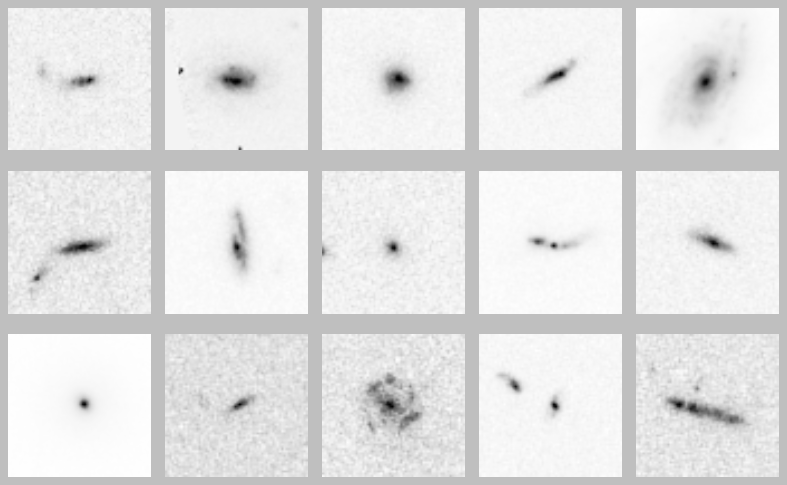

In [55]:
plt.style.use('classic')
plt.figure(figsize=(10,6.5))
for i in np.arange (1,16):
    plt.subplot(3,5,i)
    if (i<5)&(i>11):
        noise = torch.randn(50, nz, 1, 1, device=device)
        fake = netG(noise)
        fd = fake.detach()
        plt.imshow(np.arcsinh(fd[np.random.randint(1,50),0,10:-10,10:-10]),origin='lower',cmap='Greys')
        plt.axis('off')
    else:
        n = np.int(np.random.uniform(0,len(ra1)-1))
        data = cut(ra1[n],dec1[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
        if data[0,0]!=0 :
            angle = np.random.uniform(0,180)
            s = ndimage.rotate(data,angle,mode='nearest',reshape=False)
            da = np.arcsinh(s[18:-18,18:-18])
            plt.imshow(da,origin='lower',cmap='Greys')
            plt.axis('off')

 
plt.tight_layout()
plt.savefig('../plots/GAN_from_noise.png')